# Common Chemical Fragments 2: Morgan bits

This post is a followup to the recent post looking at the [1000 most common "chemical words" in PubChem Compound](https://greglandrum.github.io/rdkit-blog/posts/2025-05-09-common-chemical-words-1.html).
Here we use the same data set but look at how often circular atom environments (expressed via Morgan fingerprint bits) occur across all of the compounds.

The PubChem team has done a much deeper and more thorough analysis of the [atom environments in PubChem Compound](https://link.springer.com/article/10.1186/s13321-015-0076-4); it's definitely worth reading that paper if you are interested in this stuff.

In [1]:
from rdkit import Chem
from rdkit.Chem import BRICS
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import rdkit

from collections import Counter

from matplotlib import pyplot as plt
%matplotlib inline
print(rdkit.__version__)
import os,time,glob
print( time.asctime())

2025.03.2
Thu May 22 08:14:31 2025


The [earlier blog post](https://greglandrum.github.io/rdkit-blog/posts/2025-05-09-common-chemical-words-1.html) includes the code for how I processed the molecules, generated fingerprints, and counted bits.

# Initial workup of the results

## How many unique bits are there?

Here we look at the fingerprint results.

Start by looking at how we stored the data. For that we just need to read from one of the files:

In [4]:
import pickle, gzip
infs = glob.glob('/fileserver/pine/pine1/glandrum/pubchem/Compound/Compound*.pkl.gz')
inf = gzip.open(infs[0],'rb')
brics,fps = pickle.load(inf)

The `fps` variable contains a Counter keyed by (bit ID, atomic number of central atom, radius). I used this triple instead of just the bit ID to minimize problems with collisions.

In [9]:
list(fps.keys())[0]

(10565946, 8, 1)

The values of the counter object are the number of times the feature occurs in the file:

In [10]:
fps[(10565946, 8, 1)]

3232

To get the full set of counts we need to process each of the pickle files and create one giant dictionary. This takes a while:

In [11]:
import pickle, gzip

infs = glob.glob('/fileserver/pine/pine1/glandrum/pubchem/Compound/Compound*.pkl.gz')
all_counts = Counter()
for i,fname in enumerate(infs):
    print(i+1,fname,len(all_counts.keys()))
    with gzip.open(fname,'rb') as inf:
        _,fps = pickle.load(inf)
    for key,val in fps.items():
        all_counts[key]+=val

1 /fileserver/pine/pine1/glandrum/pubchem/Compound/Compound_099000001_099500000.pkl.gz 0
2 /fileserver/pine/pine1/glandrum/pubchem/Compound/Compound_016000001_016500000.pkl.gz 62435
3 /fileserver/pine/pine1/glandrum/pubchem/Compound/Compound_000000001_000500000.pkl.gz 924475
4 /fileserver/pine/pine1/glandrum/pubchem/Compound/Compound_016500001_017000000.pkl.gz 2413059
5 /fileserver/pine/pine1/glandrum/pubchem/Compound/Compound_000500001_001000000.pkl.gz 2743787
6 /fileserver/pine/pine1/glandrum/pubchem/Compound/Compound_017000001_017500000.pkl.gz 3375777
7 /fileserver/pine/pine1/glandrum/pubchem/Compound/Compound_001000001_001500000.pkl.gz 3441101
8 /fileserver/pine/pine1/glandrum/pubchem/Compound/Compound_017500001_018000000.pkl.gz 3567283
9 /fileserver/pine/pine1/glandrum/pubchem/Compound/Compound_001500001_002000000.pkl.gz 3984123
10 /fileserver/pine/pine1/glandrum/pubchem/Compound/Compound_018000001_018500000.pkl.gz 4094396
11 /fileserver/pine/pine1/glandrum/pubchem/Compound/Compou

Save that so that we don't have to repeat the work if we need to use the data again;

In [12]:
with gzip.open('../data/chemical_words_pubchem_counts_fps.pkl.gz','wb+') as outf:
    pickle.dump(all_counts,outf)

Get the bit information + counts in sorted order:

In [14]:
itms = sorted(((y,x) for x,y in all_counts.items()),reverse=True)
len(itms)

89174476

So we got around 89 million unique bits (circular atom environments) from the dataset.

Let's look at the most and least frequent bits:

In [15]:
itms[:10]

[(638213325, (3218693969, 6, 0)),
 (514726494, (3217380708, 6, 0)),
 (344587626, (951226070, 6, 1)),
 (236172134, (2968968094, 6, 0)),
 (228100149, (2245384272, 6, 0)),
 (227187604, (2246728737, 6, 0)),
 (155556500, (864942730, 8, 0)),
 (143987378, (98513984, 6, 1)),
 (105456574, (2246699815, 6, 0)),
 (93444163, (1510328189, 8, 1))]

To understand that output: The most common bit, #3218693969, occurs 638213325 times in the dataset. The bit itself is radius zero, centered on a C. The third most common bit, #951226070, is a radius one bit centered on C.


In [18]:
len([x for x in itms if x[0]==1])

42140583

There are >42 million bits that only occur one time, so looking at any of those in detail is probably not particularly informative.

When I looked at the BRICS results, it was easy to look at exactly what the fragments themselves were since we had a SMILES for each fragment. That is not the case here, in order to get more information about a particular bit, we have to actually find molecules that set it and then extract the info from them.

Here's code to do that:

In [84]:
from rdkit.Chem import rdFingerprintGenerator
fpg = rdFingerprintGenerator.GetMorganGenerator(radius=3)
from rdkit import rdBase

def get_fp(m):
    ao = rdFingerprintGenerator.AdditionalOutput()
    ao.AllocateBitInfoMap()
    fp = fpg.GetSparseCountFingerprint(m, additionalOutput=ao)
    return fp,ao
    
def find_atom_envs_for_bits(bits,fns):
    needed = list(bits)
    res = {}
    for tpl in needed:
        res[tpl] = None

    blocker = rdBase.BlockLogs()
    for fn in fns:
        with gzip.open(fn, 'rb') as inf:
            suppl = Chem.ForwardSDMolSupplier(inf)
            for m in suppl:
                if m is None or m.GetNumHeavyAtoms() > 60:
                    continue
                fp,ao = get_fp(m)
                imap = ao.GetBitInfoMap()
                for tpl in needed:
                    bid,anum,rad = tpl
                    if bid in imap:
                        for aid, irad in imap[bid]:
                            if irad == rad:
                                ianum = m.GetAtomWithIdx(aid).GetAtomicNum()
                                if ianum == anum:
                                    res[tpl] = (m,aid,irad)
                                    needed.remove(tpl)
                                    break
                if not needed:
                    break
        if not needed:
            break
    return res

In [85]:
sdfs = glob.glob('/fileserver/pine/pine1/glandrum/pubchem/Compound/Compound*.sdf.gz')
t = find_atom_envs_for_bits([x[1] for x in itms[:20]],sdfs)

# make sure the results are in the same order so that our legends are correct
assert list(t.keys())==[x[1] for x in itms[:len(t)]]

And now draw the top 20 environments:

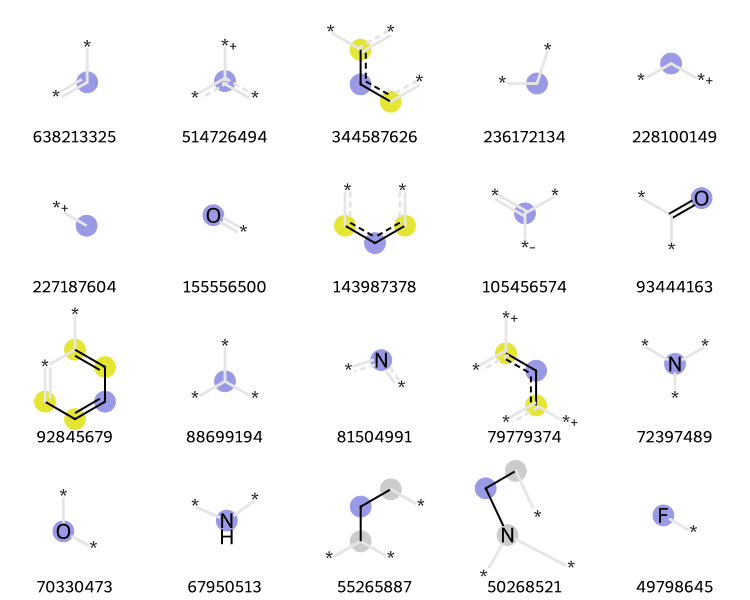

In [74]:
from IPython.display import SVG
m,aid,rad = list(t.values())[1]
SVG(Draw.DrawMorganEnvs(list(t.values()),molsPerRow=5,legends=[str(x[0]) for x in itms[:len(t)]]))

This is pretty fast for the common bits (since it's easy to find a matching molecule), but is potentially considerably more time consuming for less common bits.

Those are all radius 0-2, what is the most common radius 3 bit?

In [79]:
for idx,(cnt,(bid,anum,rad)) in enumerate(itms):
    if rad==3:
        b3 = bid
        print(f'rad=3 rank={idx}, cnt={cnt}, anum={anum}')
        break

rad=3 rank=40, cnt=21759201, anum=6


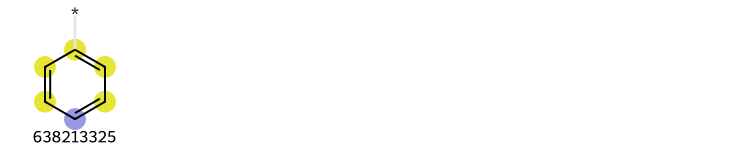

In [81]:
t = find_atom_envs_for_bits([itms[idx][1]],sdfs)
SVG(Draw.DrawMorganEnvs(list(t.values()),molsPerRow=5,legends=[str(x[0]) for x in itms[:len(t)]]))

What about the top three radius 2 and radius 3 bits?

In [93]:
idx2 = []
idx3 = []
for idx,(cnt,(bid,anum,rad)) in enumerate(itms):
    if len(idx3)<3 and rad==3:
        idx3.append(idx)
        print(f'rad=3 rank={idx}, cnt={cnt}, anum={anum}')
    elif len(idx2)<3 and rad==2:
        idx2.append(idx)
        print(f'rad=2 rank={idx}, cnt={cnt}, anum={anum}')
    if len(idx2)==3 and len(idx3)==3:
        break

rad=2 rank=10, cnt=92845679, anum=6
rad=2 rank=38, cnt=21958195, anum=6
rad=3 rank=40, cnt=21759201, anum=6
rad=2 rank=45, cnt=19440929, anum=6
rad=3 rank=69, cnt=12502015, anum=6
rad=3 rank=83, cnt=11288141, anum=6


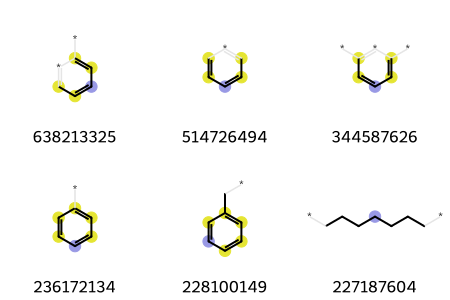

In [94]:
allidxs = idx2 + idx3
t = find_atom_envs_for_bits([itms[idx][1] for idx in allidxs],sdfs)
SVG(Draw.DrawMorganEnvs(list(t.values()),molsPerRow=3,legends=[str(x[0]) for x in itms[:len(t)]]))

It's not terribly surprising that these all involve phenyl rings.

Finding less common bits than these starts to take quite a long time, so I will stop here.